# Feature Selection Mutual Information Score

In [563]:
from warnings import filterwarnings
filterwarnings('ignore')

In [564]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')

In [565]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [567]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [568]:
s = df.isna().sum()
s = s[s>0]
s

Age         177
Cabin       687
Embarked      2
dtype: int64

# Seprate X and Y 

In [569]:
X = df.drop(columns=['PassengerId','Name','Ticket','Cabin','Survived'])
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [570]:
Y = df[['Survived']]
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


# Seprate CAT and CON

In [571]:
cat = list(X.columns[X.dtypes=='object'])
cat

['Sex', 'Embarked']

In [572]:
con = list(X.columns[X.dtypes!='object'])
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# create a PIPELINE for feature selection(ordinal encoder)

In [573]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

In [574]:
num_pipe = Pipeline(steps=[('impute',SimpleImputer(strategy='median')),
                           ('scaler',StandardScaler())])

In [575]:
cat_pipe = Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')),
                           ('odinal',OrdinalEncoder())])

In [576]:
pre1 = ColumnTransformer([('num',num_pipe,con),
                          ('cat',cat_pipe,cat)]).set_output(transform='pandas')

In [577]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('odinal', OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [578]:
X_pre1 = pre1.fit_transform(X)
X_pre1.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


# Perfrom FEATURE SELECTION with mutual information score

In [579]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_pre1,Y)

In [580]:
mi = pd.Series(mi)
mi

0    0.066751
1    0.032719
2    0.027709
3    0.040034
4    0.134154
5    0.172140
6    0.000000
dtype: float64

In [581]:
mi.index = X_pre1.columns
mi

num__Pclass      0.066751
num__Age         0.032719
num__SibSp       0.027709
num__Parch       0.040034
num__Fare        0.134154
cat__Sex         0.172140
cat__Embarked    0.000000
dtype: float64

In [582]:
mi = mi.sort_values(ascending=False)
mi

cat__Sex         0.172140
num__Fare        0.134154
num__Pclass      0.066751
num__Parch       0.040034
num__Age         0.032719
num__SibSp       0.027709
cat__Embarked    0.000000
dtype: float64

<Axes: >

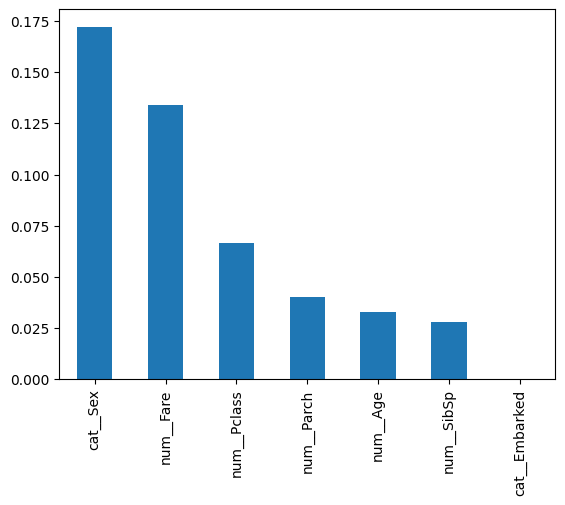

In [583]:
mi.plot(kind='bar')

#  Select top 5 Feature 

In [584]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif,k=5)
sel.fit(X_pre1,Y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__Age', 'num__Parch', 'num__Fare', 'cat__Sex'],
      dtype=object)

# Get only the original columns name 

In [585]:
sel_cols[0].split('__')

['num', 'Pclass']

In [586]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [587]:
imp_cols

['Pclass', 'Age', 'Parch', 'Fare', 'Sex']

In [588]:
X_imp = X[imp_cols]
X_imp


,Pclass,Age,Parch,Fare,Sex
0,3,22.0,0,7.2500,male
1,1,38.0,0,71.2833,female
2,3,26.0,0,7.9250,female
3,1,35.0,0,53.1000,female
4,3,35.0,0,8.0500,male
...,...,...,...,...,...
886,2,27.0,0,13.0000,male
887,1,19.0,0,30.0000,female
888,3,NaN,2,23.4500,female
889,1,26.0,0,30.0000,male


# Seprate cat and con for selected columns 

In [589]:
cat_sel = list(X_imp.columns[X_imp.dtypes=='object'])
cat_sel

['Sex']

In [590]:
con_sel = list(X_imp.columns[X_imp.dtypes!='object'])
con_sel

['Pclass', 'Age', 'Parch', 'Fare']

# Create a Final Perprocessing PIPELINE (OHE)

In [591]:
from sklearn.preprocessing import OneHotEncoder

In [592]:
num_pipe2 = Pipeline(steps=[('impute',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler())])

In [593]:
cat_pipe2 = Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')),
                            ('OHE',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])

In [594]:
pre2 = ColumnTransformer([('num',num_pipe2,con_sel),
                          ('cat',cat_pipe2,cat_sel)]).set_output(transform='pandas')

In [595]:
pre2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHE',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex'])])

In [596]:
X_sel_pre = pre2.fit_transform(X_imp)
X_sel_pre.head()

,num__Pclass,num__Age,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,-0.565736,-0.473674,-0.502445,0.0,1.0
1,-1.566107,0.663861,-0.473674,0.786845,1.0,0.0
2,0.827377,-0.258337,-0.473674,-0.488854,1.0,0.0
3,-1.566107,0.433312,-0.473674,0.420730,1.0,0.0
4,0.827377,0.433312,-0.473674,-0.486337,0.0,1.0


# Apply TRAIN TEST SPLIT for X_sel_pre

In [597]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_sel_pre,Y,random_state=41)

In [598]:
xtrain.shape

(668, 6)

In [599]:
xtest.shape

(223, 6)

# Create a LOGISTIC REGRESSION ALGO

In [600]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(xtrain,ytrain)

LogisticRegression()

In [601]:
model.score(xtrain,ytrain)


0.7874251497005988

In [602]:
model.score(xtest,ytest)

0.7982062780269058

# Predict Results for TRAIN and TEST 

In [603]:
ypred_tr = model.predict(xtrain)
ypred_tr[0:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [604]:
ypred_ts = model.predict(xtest)
ypred_ts[0:5]

array([0, 0, 1, 0, 1], dtype=int64)

# Create a CONFUSION MATRIX

In [605]:
c = model.classes_
c

array([0, 1], dtype=int64)

In [606]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix


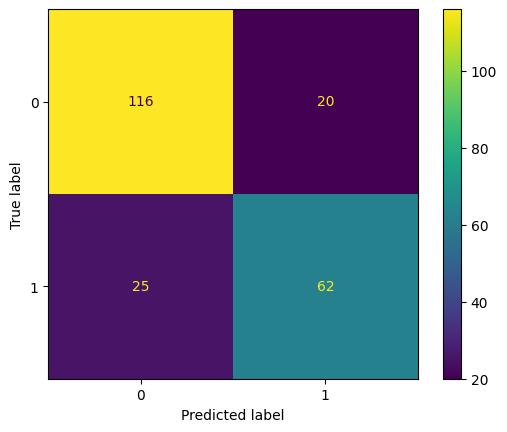

In [607]:
cf = confusion_matrix(ytest,ypred_ts)
cfd = ConfusionMatrixDisplay(cf,display_labels=c)
cfd.plot()

# Classification report

In [608]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred_ts))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       136
           1       0.76      0.71      0.73        87

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



# Predict out of sample data 

In [609]:
xnew = pd.read_csv('test_titanic.csv')

In [610]:
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Transform the above data 

In [611]:
xnew_pre = pre2.transform(xnew)

In [612]:
xnew_pre[0:5]

,num__Pclass,num__Age,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,0.394887,-0.473674,-0.490783,0.0,1.0
1,0.827377,1.355510,-0.473674,-0.507479,1.0,0.0
2,-0.369365,2.508257,-0.473674,-0.453367,0.0,1.0
3,0.827377,-0.181487,-0.473674,-0.474005,0.0,1.0
4,0.827377,-0.565736,0.767630,-0.401017,1.0,0.0


# Predict the RESULTS 

In [618]:
preds = model.predict(xnew_pre)
preds[0:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [617]:
prob = model.predict_proba(xnew_pre)
prob[0:5]

array([[0.9201158 , 0.0798842 ],
       [0.63128634, 0.36871366],
       [0.91518874, 0.08481126],
       [0.89409128, 0.10590872],
       [0.46741856, 0.53258144]])

In [633]:
import numpy as np
max_prob = np.max(prob , axis=1)
max_prob[0:5]

array([0.9201158 , 0.63128634, 0.91518874, 0.89409128, 0.53258144])

# Save above file to CSV

In [629]:
df_final = xnew[['PassengerId']]

In [635]:
df_final['Survived_pred']=preds
df_final['Survived_prob'] =max_prob

In [636]:
df_final.head()

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.920116
1,893,0,0.631286
2,894,0,0.915189
3,895,0,0.894091
4,896,1,0.532581


# Save the above file to new results csv

In [637]:
df_final.to_csv('fsResults.csv',index=False)